In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
from feature_engine.selection import DropCorrelatedFeatures

In [2]:
# 타이타닉 데이터로부터 보루타 알고리즘으로 피처를 선정

df = sns.load_dataset('titanic')

# 데이터 전처리

df = df.dropna(subset=['age', 'embarked', 'deck'])
df['sex'] = df['sex'].map({'male':0, 'female':1})
df['embarked'] = df['embarked'].astype('category').cat.codes
df['deck'] = df['deck'].astype('category').cat.codes

# 필요한 피처만 추출

X = df[['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = df['survived']

In [3]:
## 보루타를 통한 피처 셀렉션을 위해 RandomForestClassifier

rf = RandomForestClassifier(class_weight = 'balanced', max_depth=5)

# BorutaPy 불러오기
boruta_selector = BorutaPy(rf, n_estimators = 'auto', random_state=111)
boruta_selector.fit(X.values, y.values) # 행렬로 대입

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=80,
                                          random_state=RandomState(MT19937) at 0x1A047D6E540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1A047D6E540)

In [4]:
print('선택된 특성', X.columns[boruta_selector.support_].tolist())

선택된 특성 ['sex', 'age', 'fare']


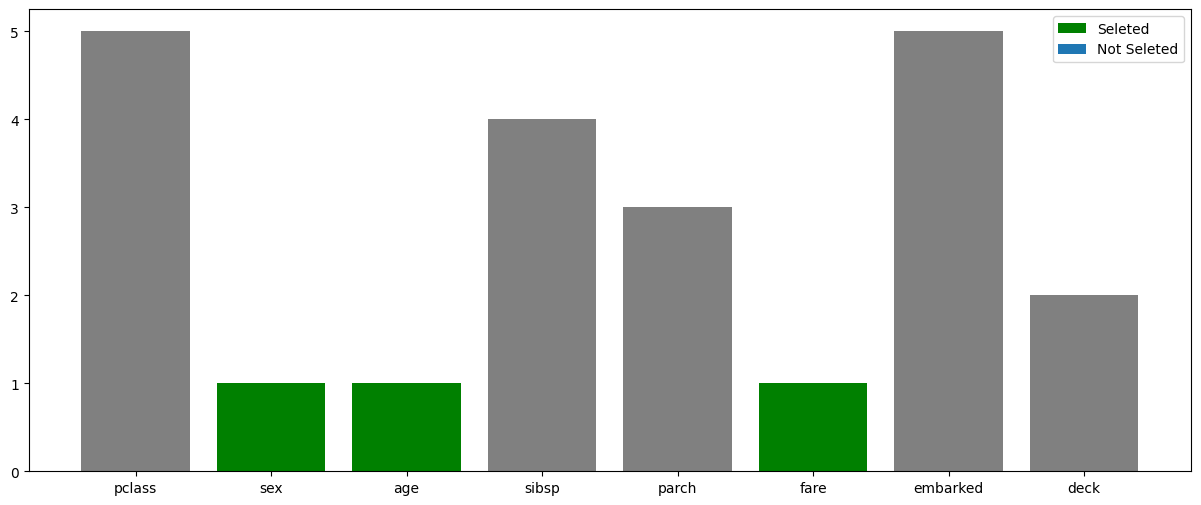

In [5]:
import matplotlib.pyplot as plt

green_area = X.columns[boruta_selector.support_].tolist()
blue_area = X.columns[boruta_selector.support_weak_].tolist()

# 중요도 랭킹으로 확인하기
feature_importance = boruta_selector.ranking_

# 시각화로 살펴보기

plt.figure(figsize=(15,6))
plt.bar(X.columns, feature_importance,color= 'grey')
plt.bar(green_area, [1]*len(green_area), color='green', label='Seleted')
plt.bar(blue_area, [2]*len(blue_area), color='blue', label='Not Seleted')
plt.legend()

## Shap vlaue( 샤플리 값 )
- 샤플리 값의 작동 방식을 이해하자!
- 간단한 예시를 통해 어떤 식으로 계산하는지 이해하기!
    - 세 명의 플레이어(피처) A, B, C가 협력해서 100의 매출들 달성 ( ML y값을 예측한다.)
    - A와 B가 같이 협력을 하면 매출을 60을 달성
    - B와 C가 같이 협력을 하면 매출을 50을 달성
    - A, B,C 가 모두 협력하면 100을 달성
    
    - 기여도는 어떤 식으로 계산이 될까?
        - 각 조합의 기여도를 계산
        - 공집합 = 기여도가 0 A,B,C 모두 진행 X
        - A만 한 경우 20, B만한 경우 30, C만 경우 10
        - A,B = 60, B,C = 50, A,C = 40
        - A,B,C = 100
    -샤플리 값 A를 계산한다고 하면 샤플리값 =  1/6(20) +  1/6(10) + 1/6(40-10) + 1/6(60-30) + 1/6(100-60)

- Machine Learning 에서 샤플리 값을 계산한다면?
    - **Feature 모델의 예측값에 기여한 정도를 계산하기 위해 샤플리값을 사용한다.**
    - **피처들의 조합으로 게임 플레이어처럼 생각하고, 모델의 예측값을 협력의 결과로 본다.**
    
    - 데이터 포인트에 대해 모델의 예측값 계산
    - 모든 특성의 조합에서의 예측값이 변화를 계산
    - 각 특성의 기여도를 평균화하여서 샤플리 값을 계산

### 샤플리 값을 타이타닉 데이터로 설명을 해보면!
- 타이타닉의 주요 특성(피처) pclass, sex, age, fare 타겟변수는 survived
- 랜덤포레스트를 학습해서 특정 포인트에서 샤플리값을 계산해 본다.


----
- 특성 N은
    - Pclass(객실등급), Sex(성별), Age(나이), Fare(요금)
    
- **모든 특성의 조합을 생각해야 한다.**
    - 공집합,
    - Pclass
    - Sex
    - Age
    - Fare
    - (Pclass, Sex)
    - ...
    - (Pclass, Sex, Age, Fare)
    - 모든 조합을 생성한다.
    
- 모델의 예측값을 계산
    - 수식에서 바라보면
    - S = pclass i = sex , pclass와 sex를 함께 사용하여 예측값을 계산
    - f(SU{i} - f(S}) 특성인 sex 추가가 되었을 때 예측값에 미친 변화량을 계산

- 평균화
    - 모든 부분집합 (S)에 대한 기여도를 계산하는 것, 이를 평균화하여 특성 (i) 샤플리 값을 얻는 것

- 특정 데이터 포인트에 대해 샤플리값을 디 다계산이 된다.
- 변수     샤플리값     해석
- pclass  -0.3     낮은 객실등급들이 생존 확률을 감소시킨다.
- sex     +0.5     여성의 경우 생존확률 증가시킨다.
- age     -0.2     나이가 많아질수록 생존에 대한 확률이 감소
- fare    +0.1     운임이 높으면 생존확률을 증가시킨다.

    **- 타이타닉의 도메인을 이해하고 샤플리값을 바라보면 피처에 대한 선택과 인사이트를 상대적으로 쉽게 정리할 수 있다.**
    

In [6]:
from sklearn.model_selection import train_test_split

X= df[['sex','age','fare','pclass']]
y= df['survived']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=111)

In [8]:
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=111)

In [9]:
# Shap 값 구하기
# SHAP Explainer

explainer=shap.TreeExplainer(model)

In [10]:
# shap_values 추출
shap_values=explainer.shap_values(X_test)

In [11]:
shap_values

array([[[ 2.21466861e-01, -2.21466861e-01],
        [ 1.13594209e-01, -1.13594209e-01],
        [-2.06209208e-01,  2.06209208e-01],
        [-2.69185556e-04,  2.69185556e-04]],

       [[-1.50051199e-01,  1.50051199e-01],
        [-7.65689293e-02,  7.65689293e-02],
        [-6.35779054e-02,  6.35779054e-02],
        [-2.12192893e-02,  2.12192893e-02]],

       [[ 3.06207651e-01, -3.06207651e-01],
        [ 3.82706060e-02, -3.82706060e-02],
        [ 2.08374207e-01, -2.08374207e-01],
        [ 5.73021357e-03, -5.73021357e-03]],

       [[-1.94451182e-01,  1.94451182e-01],
        [-5.48092467e-02,  5.48092467e-02],
        [-6.84494051e-02,  6.84494051e-02],
        [-3.70748949e-03,  3.70748949e-03]],

       [[ 2.00072782e-01, -2.00072782e-01],
        [-3.04022517e-02,  3.04022517e-02],
        [-1.16545064e-01,  1.16545064e-01],
        [-4.54278848e-03,  4.54278848e-03]],

       [[-1.70773447e-01,  1.70773447e-01],
        [-7.32136894e-02,  7.32136894e-02],
        [-7.22896634e-

Class 0 SHAP Summary Plot


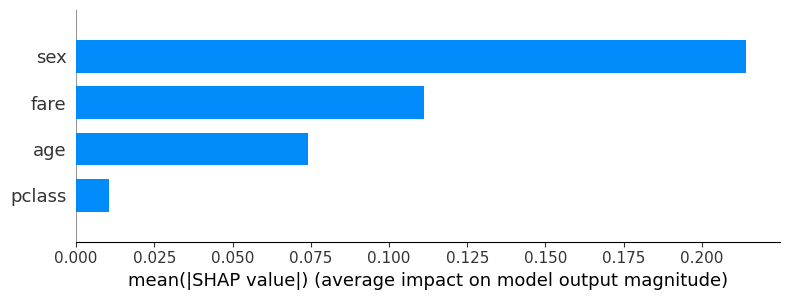

Class 1 SHAP Summary Plot


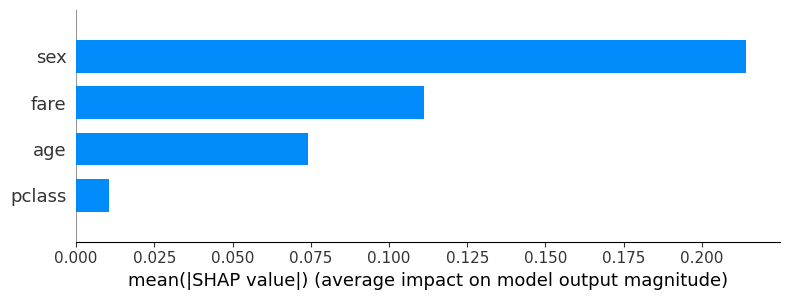

In [18]:
# 각 클래스별로 SHAP 요약 플롯 생성
for i in range(shap_values.shape[2]):  # 클래스 수 만큼 반복
    print(f"Class {i} SHAP Summary Plot")
    shap.summary_plot(shap_values[:, :, i], X_test, plot_type='bar', feature_names=X_test.columns.tolist())

## Shap의 그래프를 더 살펴보고 해당 그래프를 해석해 보자!

- summary_plot : 특정 중요도, 기여도 확인
- bar_plot : 중요도 순서 확인
- force_plot : 개별 예측 해석
- decision_plot : 예측 경로에 대한 분석
- dependence_plot : 특성과 출력간의 관계 분석
- interaction_plot : 상호작용 분석
- waterfall_plot : 예측 생성 과정 단계별 설명
- heatmap_plot : 상호작용간의 분석
- beesarm plot : 분산, 중심성향 분석

In [29]:
# 특정 클래스 선택
shap_values_class_0 = shap_values[:, :, 0]

# DataFrame 생성
shap_df = pd.DataFrame(shap_values_class_0, columns=X_test.columns)
print("SHAP Values (Class 0):")
print(shap_df_class_0.head())

# 모든 클래스 SHAP 값 합산
shap_values_sum = shap_values.sum(axis=2)
shap_df_sum = pd.DataFrame(shap_values_sum, columns=X_test.columns)
print("Summed SHAP Values (All Classes):")
print(shap_df_sum.head())

SHAP Values (Class 0):
        sex       age      fare    pclass
0  0.221467  0.113594 -0.206209 -0.000269
1 -0.150051 -0.076569 -0.063578 -0.021219
2  0.306208  0.038271  0.208374  0.005730
3 -0.194451 -0.054809 -0.068449 -0.003707
4  0.200073 -0.030402 -0.116545 -0.004543
Summed SHAP Values (All Classes):
            sex           age          fare        pclass
0 -8.326673e-17 -6.938894e-17  6.106227e-16  3.198396e-18
1  2.220446e-16  4.163336e-17  1.387779e-17  4.857226e-17
2  1.665335e-16  1.249001e-16  2.775558e-16 -1.474515e-17
3  7.494005e-16  2.220446e-16  8.326673e-17  4.336809e-18
4 -2.775558e-16  4.163336e-17 -4.163336e-17  0.000000e+00


In [30]:
## shap_df 중요도를 계산 후 정렬해서 보기

shap_mean_importance =shap_df.abs().mean(axis=0).sort_values(ascending=False)

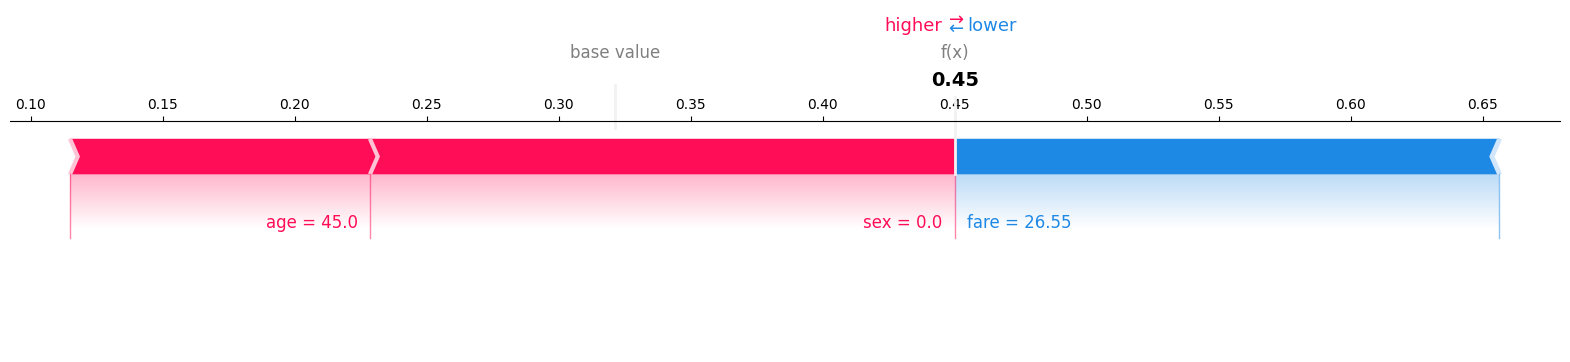

In [32]:
# SHAP 값의 특정 클래스 선택
shap_values_for_class = shap_values[:, :, 0]  # 첫 번째 클래스 선택

# Force Plot 생성
shap.force_plot(
    explainer.expected_value[0],  # 첫 번째 클래스의 기대값
    shap_values_for_class[0, :],  # 첫 번째 샘플, 첫 번째 클래스의 SHAP 값
    X_test.iloc[0, :],            # 첫 번째 샘플의 feature 값
    matplotlib=True
)


- 결과해석
    - base_value  모델의 평균적인 예측을 말하는 것 0.3
- 특성에 대한 기여도를 확인해야 한다(shap)
    - 색상
    - 빨간색은 특성이 모델 예측값을 증가시키는 방향으로 기여
    - 파란색은 해당 특성이 모델 예측값을 감소시키는 방향으로 기여했다.
    
- f(x):0.45
    - 최종 모델 예측값으로, 모든 특성의 기여도를 합산한 값으로 최종 예측값이 0.44
- age, sex, fare 각 데이터 포인트 실제 값

- base_value 0.3에서 시작, 특성의 기여도를 더하거나 빼서 최종 예측값이 0.44로 도달한다.

- age 0.1증가킨다. 나이가 45일 때 생존 가능성을 증가하는 방향으로 작용
- sex 0 남성, 0.2 영향을 더 줬다.
- fare -0.206 영향 감소시켰다.

In [34]:
shap_values[0][0,:]

array([ 0.22146686, -0.22146686])

In [35]:
X_test.iloc[0,:]

sex        0.00
age       45.00
fare      26.55
pclass     1.00
Name: 536, dtype: float64

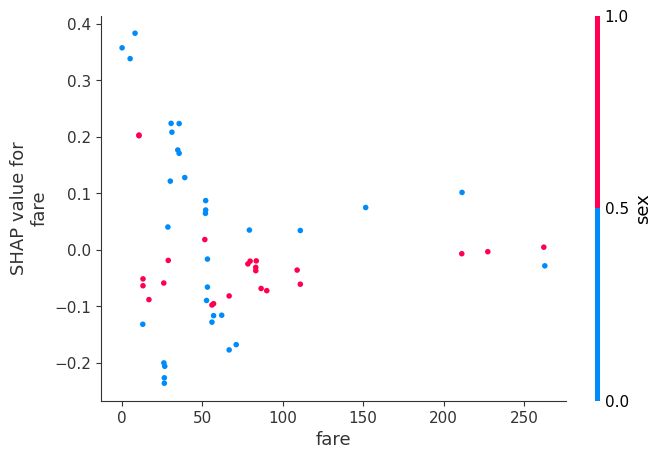

In [39]:
# 특정 클래스 선택
shap_values_for_class = shap_values[:, :, 0]  # 첫 번째 클래스 SHAP 값 선택

# Dependence Plot 생성
shap.dependence_plot('fare', shap_values_for_class, X_test)

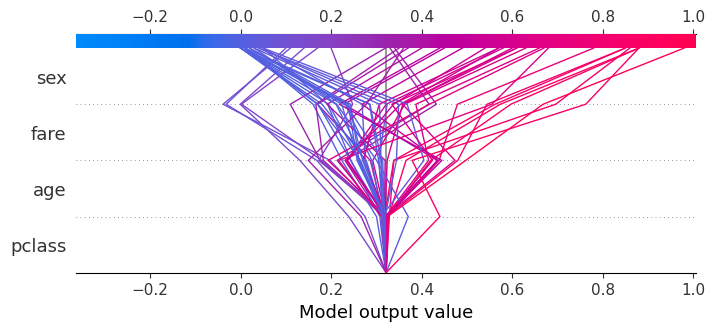

In [40]:
# 특정 클래스 선택
shap_values_for_class = shap_values[:, :, 0]  # 첫 번째 클래스 선택

# Feature Names
feature_names = X_test.columns.tolist()

# Decision Plot 생성
shap.decision_plot(
    explainer.expected_value[0],  # 첫 번째 클래스의 기대값
    shap_values_for_class,        # 첫 번째 클래스의 SHAP 값
    X_test,                       # feature 값
    feature_names=feature_names   # feature 이름
)


- 특정 데이터의 포인트에서 모델의 예측경로를 시각적으로 표현한 것
- 예측값에 기여한 누적 영향을 보여주는 것
- X축 (모델이 예측한 결과값의 스케일)
    - 예측값이 + 특정 클래스 생존가능성이 증가
    - 갈수록 생존에 대해서 불가능하게 만드는 것
- Y축
    - 피처
    - 모델이 예측을 내릴 때 사용한 주요 특성들이 나열
- 선의 기울기
    - 완만한 기울기 : 예측값에 크게 기여하지 않았다.
    - 급격한 기울기 : 예측값에 크게 영향을 주었다.
- 선의 색상
    - 파란색 : 특성 값이 낮은 것
    - 빨간색 : 특성 값이 높은 것

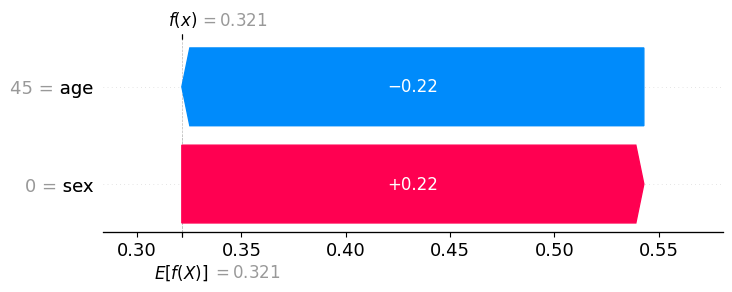

In [41]:
## 0번째 피처의 특성들에 shap 값 보면서 확인하는 것
shap.waterfall_plot(
    shap.Explanation(
    values= shap_values[0][0],
    base_values = explainer.expected_value[0],
    data = X_test.iloc[0])
)

In [42]:
## shap값을 통해 출력된 피처와 base 모델로 학습한 것을 비교하여 정말 피처 셀렉션이 긍정적인 영향을 주는가?


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [43]:
tt=sns.load_dataset('titanic')

In [44]:
tt=tt.drop(columns = ['deck','embark_town','class','alive','who','adult_male','alone'])

In [45]:
## 간단한 전처리
## 결측치는 다 제거하기
tt=tt.dropna()

In [46]:
tt

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
889,1,1,male,26.0,0,0,30.0000,C


In [47]:
tt['sex'] = tt['sex'].map({'male':0,'female':1})
tt['embarked'] = tt['embarked'].map({'C':0,'Q':1,'S':2})

# 전처리 다 진행

In [48]:
## X, y 로 데이터 나누기

X = tt.drop(columns = ['survived'])
y = tt['survived']

In [49]:
import numpy as np

In [50]:
## 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=111)
## cross_val
## base라인 모델링
rf_base=RandomForestClassifier(random_state=111, max_depth=2)
base_cv_scores=cross_val_score(rf_base, X_train, y_train, cv=5, scoring='accuracy')
print(np.mean(base_cv_scores),'교차검증 train')
## test 값으로 실제 성능 확인
rf_base.fit(X_train, y_train)
base_pred = rf_base.predict(X_test)
base_acc_test = accuracy_score(y_test, base_pred)
print(base_acc_test,'test 결과')

## shap 피처 셀렉한 것으로 모델링
explainer = shap.TreeExplainer(rf_base)
shap_values = explainer.shap_values(X_train)

0.7790909090909091 교차검증 train
0.8177570093457944 test 결과


In [51]:
## shap 중요도 계산
## 피처에 적용하기

shap_importance=np.abs(shap_values[1]).mean(axis=0)
importance_features =X_train.columns[np.argsort(shap_importance)][::-1][:2]

## trian 데이터에서 특성으로 추출

X_train_selected = X_train[importance_features]
X_test_selected = X_test[importance_features]

In [52]:
rf_selected=RandomForestClassifier(random_state=111, max_depth=2)
selected_cv_scores=cross_val_score(rf_selected, X_train_selected, y_train, cv=5, scoring='accuracy')
print(np.mean(selected_cv_scores),'교차검증 train')

## test 검증
rf_selected.fit(X_train_selected, y_train)
selected_y_pred = rf_selected.predict(X_test_selected)

# 정확도 측정

selected_acc_test = accuracy_score(y_test, selected_y_pred)
print(selected_acc_test,'test 결과')


0.771090909090909 교차검증 train
0.822429906542056 test 결과


In [53]:
## 피처의 중요도를 선택했을 때 오히려 더 안 좋은 성능을 보였다.
## 데이터 수가 너무 적은 것도 있고, 전처리 안 하고 날려서 성능을 비교하는 게 좀 너무 적고
## 전처리나 다른 피처에 대한 엔지니어링 작업도 없었고,
## 이미 데이터 자체가 피처가 빠지면 성능이 떨어질 수 밖에 없는 설명력의 상황일 수 있다.
## train 훨씬 낮고 test가 높은 과소적합의 상태이기 때문에 이 부분을 이야기하게는 모순이다.